# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

В данном проекте я оцениваю выгоду от внедрения новой функциональности в сервис бронирования. Данная функциональность оценивает, насколько большая вероятность, что данный клиент отменит заказ и на основе этого предлагает внести предоплату за бронирование. 

По ходу проекта я вначале загружаю данные, который уже предварительно разбиты на обучающую и валидационную выборки. Далее я исследую и обрабатываю данные. Я оцениваю прибыль отеля без введения новой функциональности. После этого я обучаю модель классификации и оцениваю прибыль, которую принесёт введение данноё новой функциональности за год. 

В финальной части проекта я рассматриваю, какие признаки характерны для клиента, который с большой вероятностью отменит бронирование.

Основные выводы проекта: нововведение позволяет существенно увеличить прибыль и за тестовый период окупает свой бюджет на разработку в среднем в 30 раз. 

### Шаг 1. Откройте файлы с данными

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ydata_profiling import ProfileReport
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
import shap

import optuna
from optuna.samplers import TPESampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
# Импортируем данные
path_train = 'https://code.s3.yandex.net/datasets/hotel_train.csv'
path_test = 'https://code.s3.yandex.net/datasets/hotel_test.csv'

if os.path.exists(path_train):
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
else:
    data_train = pd.read_csv('/datasets/hotel_train.csv')
    
if os.path.exists(path_test):
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')
else:
    data_test = pd.read_csv('/datasets/hotel_test.csv')

Посмотрим на данные.

In [ ]:
display(data_train.head())
data_test.head()

Данные загрузились корректно.

В данном разделе я загрузила данные обучающей и тренировочной выборки. 

### Шаг 2. Предобработка и исследовательский анализ данных

Посмотрим на данные в обучающей и тестовой выборке.

Описания переменных из тех задания:

•	id — номер записи;

•	adults — количество взрослых постояльцев;

•	arrival_date_year — год заезда;

•	arrival_date_month — месяц заезда;

•	arrival_date_week_number — неделя заезда;

•	arrival_date_day_of_month — день заезда;

•	babies — количество младенцев;

•	booking_changes — количество изменений параметров заказа;

•	children — количество детей от 3 до 14 лет;

•	country — гражданство постояльца;

•	customer_type — тип заказчика: (Contract — договор с юридическим лицом; Group — групповой заезд; Transient — не связано с договором или групповым заездом; Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

•	days_in_waiting_list — сколько дней заказ ожидал подтверждения;
•	distribution_channel — канал дистрибуции заказа;

•	is_canceled — отмена заказа; 

•	is_repeated_guest — признак того, что гость бронирует номер второй раз;

•	lead_time — количество дней между датой бронирования и датой прибытия;

•	meal — опции заказа: (SC — нет дополнительных опций; BB — включён завтрак; HB — включён завтрак и обед; FB — включён завтрак, обед и ужин.

•	previous_bookings_not_canceled — количество подтверждённых заказов у клиента;

•	previous_cancellations — количество отменённых заказов у клиента;
•	required_car_parking_spaces — необходимость места для автомобиля;

•	reserved_room_type — тип забронированной комнаты;

•	stays_in_weekend_nights — количество ночей в выходные дни;

•	stays_in_week_nights — количество ночей в будние дни;

•	total_nights — общее количество ночей;

•	total_of_special_requests — количество специальных отметок.

In [ ]:
display(data_train.info())
data_test.info()

Мы видим, что в данных нет пропусков. Посмотрим на некоторые переменные поподробнее.

Удалим id из данных, это нам не понадобится для нашей задачи.

In [33]:
def del_column(data, col):
    data=data.drop(col, axis=1)
    return data

In [ ]:
data_train = del_column(data_train, 'id')
data_test = del_column(data_test, 'id')

Посмотрим на отчеты по данным в выборках.

In [ ]:
# Создаю репорты
profile_train = ProfileReport(data_train, title="Train", minimal=True)
profile_test = ProfileReport(data_test, title="Test", minimal=True)

In [ ]:
# Репорт для обучающей выборки
profile_train.to_widgets()

In [ ]:
# Репорт для тестовой выборки
profile_test.to_widgets()

На основании репортом мы сразу видим некоторые закономерности в наших данных. Во-первых, наши классы не сбалансированы и лишь треть от клиентов отменили бронь. Причём данная пропорция сохраняется как в обучающей, так и в тестовой выборке. Мы будем адресовать дисбаланс классов на этапе обучения модели в следующих разделах. 

Некоторые переменные представлены в формате float, хотя по логике они должны быть целочисленными. Переведём их в int.

In [ ]:
def to_int(data, l):
    for i in l:
        data[l] = data[l].astype(int)
        return data

In [ ]:
data_train = to_int(data_train, ['lead_time', 'adults', 'children', 'babies'])
data_test = to_int(data_test, ['lead_time', 'adults', 'children', 'babies'])

У нас в данных есть stays_in_weekend_nights, stays_in_week_nights и total_nights. Первые две переменные должны суммироваться к третьей. Во-первых, я проверю, что это дейтствительно так для всех данных. Во-вторых, я удалю одну из переменных, потому что они линейно зависимы и достаточно лишь двух из трёх.

In [ ]:
# Срез данных
display(data_train.query('stays_in_weekend_nights+stays_in_week_nights!=total_nights'))
data_test.query('stays_in_weekend_nights+stays_in_week_nights!=total_nights')

Всё в порядке, данные адекватные. Удалю stays_in_week_nights.

In [ ]:
# удаляю признак
data_train = del_column(data_train, 'stays_in_week_nights')
data_test = del_column(data_test, 'stays_in_week_nights')

У нас есть данные про год, месяц, день и неделю приезда. В этих данных неделя лишняя, потому что по году, месяцу и дню можно полностью восстановить дату и допольнительное знание о том, какая это неделя года ничего не даёт. Я удаля признак arrival_date_week_number.

In [ ]:
# удаляю признак
data_train = del_column(data_train, 'arrival_date_week_number')
data_test = del_column(data_test, 'arrival_date_week_number')

Теперь посмотрю на категориальные признаки.

In [ ]:
category = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

In [ ]:
for cat in category:
    display(data_train[cat].unique())
    display(data_test[cat].unique())

В значениях некоторых переменных есть лишние пробелы. Уберём их. 

In [ ]:
for cat in category:
    data_train[cat] = data_train[cat].str.strip()
    data_test[cat] = data_test[cat].str.strip()

Когда клиент бронирует номер, у отеля уже могут быть более ранние брони на эти же даты. Колличество таких броней может быть характеристикой популярности определённых дат в отеле и являться хорошей прокси для спроса на номера отеля в определённые даты.

Для того, чтобы посчитать колличествно ранее забронированных номеров на данные даты, я восстановлю дату бронирования, дату заезда и дату выезда. Для этого вначале мне нужно преобразовать дату заезда в переменную типа datetime.

In [ ]:
data_train['arrival_date'] = (
    pd.to_datetime(data_train['arrival_date_year'].astype(str) 
                   + data_train['arrival_date_month'] + data_train['arrival_date_day_of_month'].astype(str), format='%Y%B%d')
)

data_test['arrival_date'] = (
    pd.to_datetime(data_test['arrival_date_year'].astype(str) 
                   + data_test['arrival_date_month'] + data_test['arrival_date_day_of_month'].astype(str), format='%Y%B%d')
)

Теперь восстановлю дату вызда.

In [ ]:
data_train['check_out_date'] = data_train['arrival_date'] + pd.to_timedelta(data_train['total_nights'], unit='d')
data_test['check_out_date'] = data_test['arrival_date'] + pd.to_timedelta(data_test['total_nights'], unit='d')

Теперь я восстановлю дату бронирования.

In [ ]:
data_train['booking_date'] = data_train['arrival_date'] - pd.to_timedelta(data_train['lead_time'], unit='d')
data_test['booking_date'] = data_test['arrival_date'] - pd.to_timedelta(data_test['lead_time'], unit='d')

In [ ]:
# Создаю переменную с временным интервалом бронирования
data_train['stay_interval'] = [pd.Interval(a,b)  for a,b in zip(data_train['arrival_date'], data_train['check_out_date'])]

In [ ]:
data_test['stay_interval'] = [pd.Interval(a,b)  for a,b in zip(data_test['arrival_date'], data_test['check_out_date'])]

Для определения колличества ранее забронированных номеров на пересекающиеся времена я буду проверять, пересекаются ли stay_interal у данного бронирования и более ренних бронирований.

In [ ]:
# Функция подсчёта пересечений
def already_booked(data):
    booked=[]
    for i in data.sort_values(by='booking_date')['stay_interval'].expanding():
        current_interval = i[i.index[-1]]
        booked.append(i.apply(lambda x: current_interval.overlaps(x)).sum()-1)
    return booked

In [ ]:
# Подсчитываю ранее забронированные номера 
data_train['booked'] = pd.Series(already_booked(data_train), index = data_train.sort_values(by='booking_date').index)
data_test['booked'] = pd.Series(already_booked(data_test), index = data_test.sort_values(by='booking_date').index)

In [10]:
# В дальнейшем я загружала сохранённые данные, которые получила после экзекуции предыдущей ячейки
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_test.csv')

In [11]:
data_train['check_out_date'] = pd.to_datetime(data_train['check_out_date'],format='%Y-%m-%d')
data_test['check_out_date'] = pd.to_datetime(data_test['check_out_date'],format='%Y-%m-%d')
data_train['arrival_date'] = pd.to_datetime(data_train['arrival_date'],format='%Y-%m-%d')
data_test['arrival_date'] = pd.to_datetime(data_test['arrival_date'],format='%Y-%m-%d')
data_train['booking_date'] = pd.to_datetime(data_train['booking_date'],format='%Y-%m-%d')
data_test['booking_date'] = pd.to_datetime(data_test['booking_date'],format='%Y-%m-%d')

Посмотрим, как соотносится колличество уже забронированных номеров и то, насколько заранее я делаю бронирование.

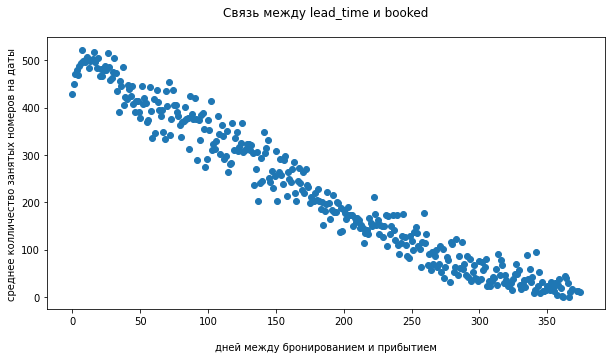

In [12]:
plt.figure(figsize = (10,5))
(
    plt.scatter(pd.concat([data_train, data_test]).groupby('lead_time')['booked'].mean().index, 
                pd.concat([data_train, data_test]).groupby('lead_time')['booked'].mean())
)
plt.xlabel('\n' 'дней между бронированием и прибытием')
plt.ylabel('среднее колличество занятых номеров на даты')
plt.title('Связь между lead_time и booked\n');


Как и кажется логичным, чем более заранее делается бронирование тем меньше занятых номеров. 

На данном шаге мы изучили наши данные. В данных нет пропусков. Мы исправили названия некоторых категориальных переменных и поменяли некоторые типы. Мы также увидели, что классы несбалансированы и это повлияет на процесс обучения моделей в следующих пунктах. Мы так же создали новую переменную, которая отражает, сколько номеров было уже забронирована на искомый период на время бронирования. Закономерно данная переменная визуально сильно отрицательно скоррелирована со временем до заезда.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

В данном пункте мы будем рассчитывать прибыль компании без внедрении системы депозитов. В рассчёте прибыли будут использованы некоторые константы, зададим их. В тех задании было сказано, что если клиент снял номер надолго, то убираются раз в два дня. Будем считать, что долгое проживание это больше 7 дней.

In [13]:
# Задаём константы
PRICES = {'A':1000, 'B': 800, 'C': 600, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
COSTS = {'A': 400, 'B': 350, 'C': 350, 'D': 550, 'E': 500, 'F': 450, 'G': 350}
DEPOSIT_COEF = 0.8 #Сколько процентов от стоимости будет депозит
LONG_STAY = 8
LONG_COEF = 0.5 #Коэффициент перед стоимостью уборки при долгом проживании

SEASON_COEFS = {'SPRING': 1.2, 'AUTUMN': 1.2, 'SUMMER': 1.4, 'WINTER':1}

SEASON_NUMBERS = {'SPRING': [3,4,5], 'AUTUMN': [9,10,11], 'SUMMER': [6,7,8], 'WINTER': [12, 1,2]}

BUDGET = 400000

Посмотрим, как часто люди бронировали проживание на долгое время.

In [14]:
display(data_train.query('total_nights>=@LONG_STAY and is_canceled==0')['total_nights'].count())
data_test.query('total_nights>=@LONG_STAY and is_canceled==0')['total_nights'].count()

530

205

Действительно, в наших данных присутствуют наблюдения, когда люди бронировали отели на долгое время и это означает, что уборка в таких номерах проводилась лишь раз в два дня и мы это должны будем отразить в рассчёте прибыли.

Теперь посмотрим, есть ли у нас наблюдения, когда заезд был в одном сезоне, а выезд в другом. Для этого построим ещё одну переменную, которая соответесвует дате последней ночи.

In [15]:
data_train['last_night_date'] = data_train['check_out_date'] + pd.to_timedelta(-1, unit='d')
data_test['last_night_date'] = data_test['check_out_date'] + pd.to_timedelta(-1, unit='d')

In [16]:
# Функция подсчёта наблюдений
def mix_seasons_count(data, season_list):
    display((
        data_train
        .query('@data["arrival_date"].dt.month in @season_list[0] '+
               'and @data["last_night_date"].dt.month in @season_list[1] and is_canceled==0')['total_nights'].count())
    )

In [17]:
# Создаю список со смешенными сезонами
mix_season_list = (
    [[SEASON_NUMBERS['SUMMER'], SEASON_NUMBERS['AUTUMN']], 
     [SEASON_NUMBERS['AUTUMN'], SEASON_NUMBERS['WINTER']], 
     [SEASON_NUMBERS['WINTER'], SEASON_NUMBERS['SPRING']], 
     [SEASON_NUMBERS['SPRING'], SEASON_NUMBERS['SUMMER']]]
)

In [18]:
for data in [data_train, data_test]:
    for s_l in mix_season_list:
        mix_seasons_count(data, s_l)

329

132

150

226

105

0

168

113

У нас тоже есть такие наблюдения и их тоже надо будет учесть при подсчёте прибыли.

In [19]:
# Создаю список с типами номеров
type_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [20]:
def profit(data):
    arrived = profit_arrived(data)
    cancelled = profit_cancelled(data)
    profit = arrived + cancelled
    return profit, arrived, cancelled

In [21]:
def profit_arrived(data):
    profit = profit_mix_season(data)+profit_same_season(data)
    return profit

Подсчитаем прибыль от броней, которые захватывали сразу два сезона.

Создадим переменную с последним днём месяца заезда.

In [22]:
import warnings
warnings.filterwarnings('ignore') # отключим предупреждения, чтобы не отвлекали

In [23]:
data_train['last_day_month'] = data_train['arrival_date']+pd.Series([relativedelta(day=31)]*len(data_train))
data_test['last_day_month'] = data_test['arrival_date']+pd.Series([relativedelta(day=31)]*len(data_test))

In [24]:
# Функция подсчёта прибыли от посетителей, которые застали два сезона
def profit_mix_season(data):
    profit_list = []
    for t in type_list:
        for s_l in mix_season_list:
            #Колличество дней в первом сезоне для коротких визитов
            count_first_half_short = (
                (data
                 .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+ 
                        'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights<@LONG_STAY')
                 ['last_day_month']
                 - data.query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0] and '+
                              '@data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights<@LONG_STAY')
                 ['arrival_date'])
                .sum().days
            )
            #Прибыль от этих дней
            profit_first_half_short = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[0])]]*PRICES[t]
                 - COSTS[t])*count_first_half_short
            )
            # Колличество дней во втором сезоне
            count_second_half_short = (
                data
                .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+
                       'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights<@LONG_STAY')
                ['total_nights'].sum() - count_first_half_short
            )
            #Прибыль от дней во втором сезоне
            profit_second_half_short = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[1])]]*PRICES[t]
                 - COSTS[t])*count_second_half_short 
            )
            # Суммарная прибыль для коротких визитов
            profit_short = profit_first_half_short + profit_second_half_short
            
            # Колличество дней в первом сезоне для долгих визитов
            count_first_half_long = (
                (data
                 .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+
                        'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights>=@LONG_STAY')
                 ['last_day_month'] 
                 - data.query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+
                              'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights>=@LONG_STAY')
                 ['arrival_date']).sum().days
            )
            # Прибыль от них
            profit_first_half_long = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[0])]]*PRICES[t] 
                 - LONG_COEF*COSTS[t])*count_first_half_long
            )
            
            # Дни во втором сезоне для долгих визитов
            count_second_half_long = (
                data.query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s_l[0]'+
                           'and @data["last_night_date"].dt.month in @s_l[1] and is_canceled==0 and total_nights>=@LONG_STAY')
                ['total_nights'].sum() - count_first_half_long
            )
            
            # Прибыль от них
            profit_second_half_long = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s_l[1])]]*PRICES[t]
                 - LONG_COEF*COSTS[t])*count_second_half_long 
            )
            # Прибыль от долгих визитов
            profit_long = profit_first_half_long + profit_second_half_long
            
            # Суммарная прибыль
            profit = profit_short + profit_long
            profit_list.append(profit)
            
    # Общая прибыль от броней, которые застали два сезона        
    return sum(profit_list)

Теперь подсчитаем прибыль от тех бронирований, которые были внутри одного сезона.

In [25]:
def profit_same_season(data):
    profit_list=[]
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Число дней недолгих визитов
            count_short = (
                data
                .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s '+
                       'and is_canceled==0 and total_nights<@LONG_STAY')['total_nights'].sum()
            )
            # Прибыль от недолгих бронирований
            profit_short = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t]
                 - COSTS[t])*count_short
            )
            
            # Число дней долгих визитов
            count_long = (
                data
                .query('reserved_room_type==@t and @data["arrival_date"].dt.month in @s '+
                       'and is_canceled==0 and total_nights>=@LONG_STAY')['total_nights'].sum()
            )
            # Прибыль от долгих бронирований
            profit_long = (
                (SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t]
                 - LONG_COEF*COSTS[t])*count_long
            )
            
            # Общая прибыль
            profit = profit_short + profit_long
            profit_list.append(profit)
    return sum(profit_list)

Теперь подсчитаем отрицательную прибыль (убыток) от тех, кто отменил бронирование.

In [26]:
def profit_cancelled(data):
    loss = []
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Считаем колличество отмененённых броней
            count = (
                data
                .query('reserved_room_type==@t and '+
                       ' @data["arrival_date"].dt.month in @s and is_canceled==1')['total_nights'].count()
            )
            # Считаем убыток
            profit = (
                -(SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t] + COSTS[t])*count
            )
            loss.append(profit)
    return sum(loss)

Теперь подсчитаем прибыль отеля за период данных обучающей выборки и за период тестовой выборки.

In [27]:
profit_train, profit_arrived_train, loss_cancelled_train = profit(data_train)

In [28]:
display(round(profit_train))
display(round(profit_arrived_train))
round(loss_cancelled_train)

44280380

81439730

-37159350

За период обучающей выборки отель заработал около 44 млн. При этом от клиентов, которые заехали прибыль была почти что 81.5 млн, но от незаехавших клиентов было практически 37 млн убытков. Как видно, есть потенциал для введения новой функциональности, потому чтои убыток от отменённых бронирований довольно большой.

По условию тех задания, новая функциональность должна окупиться за тестовый период, то есть за временной промежуток тестовой выборки. Посмотрим, какая прибыль на тестовой выборке сейчас без новой функциональности.

In [29]:
profit_test_before, profit_arrived_test_before, loss_cancelled_test_before = profit(data_test)

In [30]:
display(round(profit_test_before))
display(round(profit_arrived_test_before))
round(loss_cancelled_test_before)

20296615

39456725

-19160110

За тестовый период без новой опции прибыль 20.3 миллионов, при этом убыток от отменённых бронирований был около 19 млн.

В данном разделе я построила функции подсчёта прибыли отеля. Оказалось, что где-то половину заработенной прибыли отель теряет из-за убытков от клиентов, которые отменили бронирование. Предварительный анализ показывает, что действительно возможность требовать депозит может быть оправданной.

### Шаг 4. Разработка модели ML

В нашей выборке есть дисбаланс классов как мы видели, поэтому мы будем в процессе обучение рассматривать разные способы борьбы с дисбалансом классов. 

In [31]:
data_train['is_canceled'].value_counts(True)

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

Для нас важнее определить правильно того, кто в будущем отменит бронирование, и не очень страшно, если с человека, который в будущем приедет, мы попросим депозит, наша метрика будет recall.

#### Первичная подготовка features and targets

Перед тем, как начать рассматривать основные виды моделей и способов борьбы с дисбалансом классов, я хочу отобрать самые важные фичи и также применить feature-engineering. Для отборки наиболее важных фичей, я добавлю в переменные случайную величину и оставлю только те фичи, которые влияют на зависимую переенную больше, чем случайный признак.

Создадим features и targets.

In [35]:
def get_features(data):
    features = (
        data
        .drop(['is_canceled', 'arrival_date', 'check_out_date', 'booking_date', 'stay_interval', 
                'last_night_date', 'last_day_month'], axis=1)
    )
    return features

In [36]:
def get_target(data):
    target = data['is_canceled']
    return target

In [37]:
features_train = get_features(data_train)
features_test = get_features(data_test)
target_train = get_target(data_train)
target_test = get_target(data_test)

In [38]:
# Создаю случайную переменную
features_train['random'] = np.random.uniform(0,1,len(features_train))

In [39]:
categorical = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
numerical = (
    ['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'adults', 'children', 'babies', 'is_repeated_guest', 
     'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 
     'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'booked', 'random']
)

In [40]:
# Задаю трансформеры
numeric_transformer = StandardScaler()
categorical_transformer =OneHotEncoder(drop='first', handle_unknown='ignore')

In [41]:
# Задаю препроцессор
preprocessor = (
    ColumnTransformer([('numerical',numeric_transformer, numerical),('categorical', categorical_transformer, categorical)], 
                      remainder = 'passthrough', verbose_feature_names_out=False)
)

#### Feature selection

Я хочу отобрать те признаки, которые действительно важны для решения об отмене брони. Для этого я буду смотреть на вектор Шепли и сравнивать влияние признаков с влиянием случайного признака. 

In [33]:
# Разбиение на подвыборки для ветора Шепли
features_train_features_selection, features_valid_features_selection, target_train_features_selection, target_valid_features_selection = (
    train_test_split(features_train, target_train, test_size=0.25, random_state=42))

In [40]:
# Инициализируем случайный лес
model_features_selection = RandomForestClassifier(random_state=42, max_depth = 10, n_estimators=20)

In [35]:
pipeline_features_selection = make_pipeline(preprocessor, model_features_selection)

In [36]:
# Обучаю модель
pipeline_features_selection.fit(features_train_features_selection, target_train_features_selection)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_day_of_month',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_nights', 'booked',
                                                   'random']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['arrival_date_month', 'meal',
                                                   'country',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'customer_type'])],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

In [37]:
# Трансформирую фичи
features_train_features_selection_encoded = preprocessor.transform(features_train_features_selection).toarray()
features_names = features_train_features_selection.columns
new_features_names = preprocessor.get_feature_names_out()
features_train_encoded = pd.DataFrame(features_train_features_selection_encoded, columns=new_features_names)

features_valid_features_selection_encoded = preprocessor.transform(features_valid_features_selection).toarray()
features_names = features_valid_features_selection.columns
new_features_names = preprocessor.get_feature_names_out()
features_valid_encoded = pd.DataFrame(features_valid_features_selection_encoded, columns=new_features_names)

In [ ]:
# Получаю вектор Шепли


features_train_encoded_summary = shap.kmeans(features_train_encoded, 10)
ex = shap.KernelExplainer(model_features_selection.predict, features_train_encoded_summary)
shap_values = ex.shap_values(features_valid_encoded)

TypeError: '(slice(None, None, None), 165)' is an invalid key

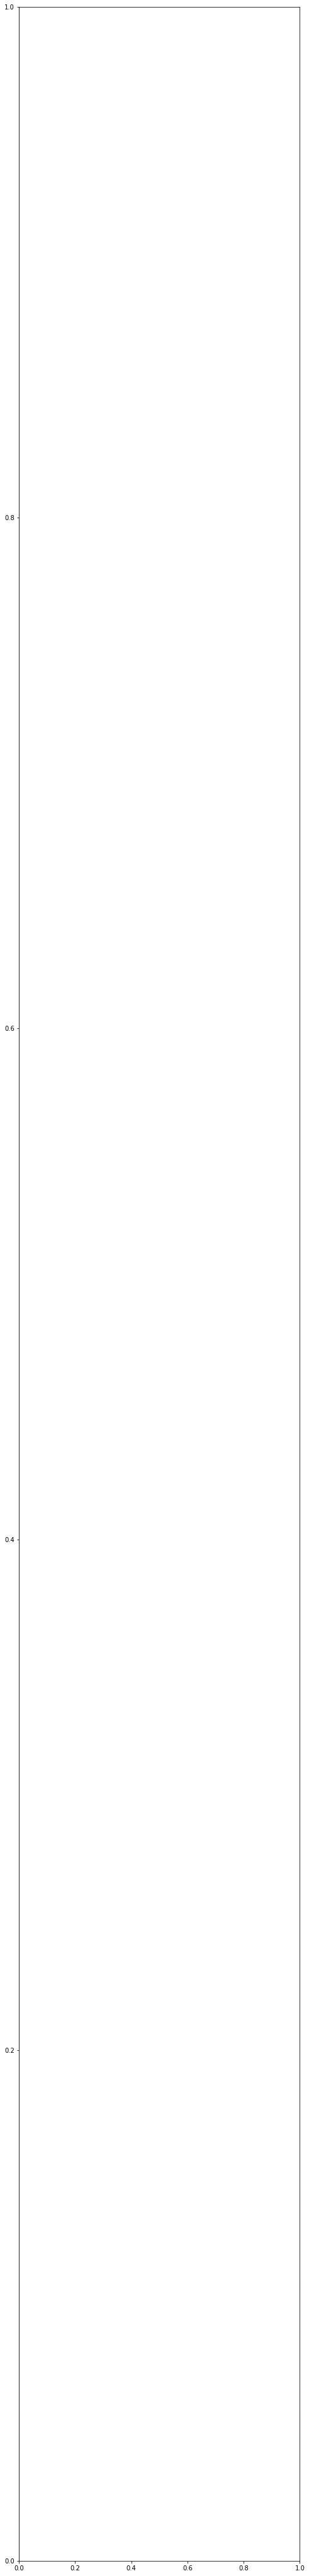

In [45]:
# График влияния разных фичей
shap.summary_plot(shap_values, features_valid_encoded, max_display=200)

Как мы видим из графика некоторые переменные очень сильно влияют на вероятность отмены (страна Португалия, много special requests). В то же время, есть переменные, которые влияют меньше, чем наша искусственная переменная random, например, babies и children, я их удалю.

In [42]:
features_train = del_column(features_train, ['babies', 'children', 'random'])

In [43]:
features_test = del_column(features_test,['babies', 'children'] )

In [44]:
numerical = (
    ['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'adults', 'is_repeated_guest', 
     'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 
     'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'booked']
)

#### Выбор модели

In [45]:
# Задаю трансформеры
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()), ('polinomial', PolynomialFeatures(2))])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [46]:
preprocessor = (
    make_column_transformer((numeric_transformer, numerical),(categorical_transformer, categorical), 
                            remainder='passthrough',
                            verbose_feature_names_out=False))

Мы будем исследовать несколько способов борьбы с дисбалансом и выбирать из трёх видов классификаторов.

In [77]:
def objective(trial):
    samplers = trial.suggest_categorical("samplers", ['undersample', 'SMOTE', 'ADASYN'])
    if samplers=='undersample':
        sample = RandomUnderSampler(random_state=42)
    elif samplers=='SMOTE':
        sample = SMOTE(random_state=42)
    else:
        sample = ADASYN(random_state=42)
    
    classifier_name = trial.suggest_categorical("classifier", ["Tree", "Forest", "Logistic_Regression"])
    
    
    if classifier_name == "Tree":
        dt_md = trial.suggest_int('max_depth', 2, 20)
        dt_sl = trial.suggest_int('min_inst', 1, 32)
        classifier_obj = DecisionTreeClassifier(max_depth=dt_md, min_samples_leaf=dt_sl, random_state=42 )
    elif classifier_name == 'Forest':
        rf_md = trial.suggest_int("rf_md", 2, 25, log=True)
        rf_n_estimators = trial.suggest_int('rf_num_estimators', 5, 50) 
        classifier_obj = RandomForestClassifier(max_depth=rf_md, n_estimators=rf_n_estimators)
    else:
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        logreg_s = trial.suggest_categorical('solver' , ['lbfgs','liblinear'])
        classifier_obj = LogisticRegression(C=logreg_c, solver=logreg_s)
    
    pipeline = Pipeline_imb([('preprocessor',preprocessor),('sample',sample), ('estimation',classifier_obj)])
    
    score = cross_val_score(pipeline, features_train, target_train, scoring='recall')
    recall_mean = score.mean() 
    return recall_mean

In [79]:
sampler = TPESampler(seed=42)
study = optuna.create_study(sampler=sampler, direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=25)

[I 2023-06-23 21:45:25,540] A new study created in memory with name: no-name-55efed39-e45e-4d95-8e81-7cbcfb55d2c3
[I 2023-06-23 21:46:07,017] Trial 0 finished with value: 0.595213936085591 and parameters: {'samplers': 'SMOTE', 'classifier': 'Tree', 'max_depth': 3, 'min_inst': 28}. Best is trial 0 with value: 0.595213936085591.
[I 2023-06-23 21:46:51,469] Trial 1 finished with value: 0.7348274899842883 and parameters: {'samplers': 'SMOTE', 'classifier': 'Tree', 'max_depth': 5, 'min_inst': 6}. Best is trial 1 with value: 0.7348274899842883.
[I 2023-06-23 21:47:32,803] Trial 2 finished with value: 0.6645828381269314 and parameters: {'samplers': 'SMOTE', 'classifier': 'Forest', 'rf_md': 3, 'rf_num_estimators': 21}. Best is trial 1 with value: 0.7348274899842883.
[I 2023-06-23 21:48:16,230] Trial 3 finished with value: 0.6941549036765162 and parameters: {'samplers': 'SMOTE', 'classifier': 'Forest', 'rf_md': 8, 'rf_num_estimators': 12}. Best is trial 1 with value: 0.7348274899842883.
[I 2023

Сохраним лучший трайл.

In [80]:
trial = study.best_trial
trial

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.743060588351915], datetime_start=datetime.datetime(2023, 6, 23, 21, 55, 49, 223725), datetime_complete=datetime.datetime(2023, 6, 23, 21, 55, 56, 357077), params={'samplers': 'undersample', 'classifier': 'Tree', 'max_depth': 4, 'min_inst': 28}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'samplers': CategoricalDistribution(choices=('undersample', 'SMOTE', 'ADASYN')), 'classifier': CategoricalDistribution(choices=('Tree', 'Forest', 'Logistic_Regression')), 'max_depth': IntDistribution(high=20, log=False, low=2, step=1), 'min_inst': IntDistribution(high=32, log=False, low=1, step=1)}, trial_id=9, value=None)

In [81]:
# Параметр модели
trial.params 

{'samplers': 'undersample',
 'classifier': 'Tree',
 'max_depth': 4,
 'min_inst': 28}

Лучшая модель это модель дерева решений глубиной 4 c минимальным колличеством листов 28 и предварительным андерсамплингом. У данной модели получился средний recall при кроссвалидации 0.743060588351915.

#### Обучаем лучшую модель

In [82]:
best_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=28, random_state=42 )

In [83]:
sampler = RandomUnderSampler(random_state=42)

In [84]:
pipeline = Pipeline_imb([('preprocessor',preprocessor),('sample',sampler), ('estimation', best_model)])

In [85]:
pipeline.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polinomial',
                                                                   PolynomialFeatures())]),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_day_of_month',
                                                   'adults',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',...
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['arrival_date_month', 'meal',
                                                   'country',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'customer_type'])],
                                   verbose_feature_names_out=False)),
                ('sample', RandomUnderSampler(random_state=42)),
                ('estimation',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=28,
                                        random_state=42))])

Проверим результативность нашей модели на тестовой выборке

In [86]:
predictions = pipeline.predict(features_test)

In [87]:
recall_test = recall_score(target_test, predictions)
recall_test

0.6746882693987769

На тестовой выборке удалось получить метрику полноты  0.67, что немного меньше, чем метрика при кросс-валидации на обучающей.

Мы обучили модель, кототорую отобрали с помощью оптимизации и получили предсказания для тестовой выборки.Теперь с помощью этих предсказаний мы будем оценивать распределение прибыли на тестовой выборке. 

Для начала мы рассчитаем прибыль от введения новой функциональности.

#### Прибыль от введения депозитов

Создадим функцию подсчёта прибыли после введения системы депозитов.

In [88]:
# Функция подсчёта прибыли после введения депозитов
def profit_deposit(data):
    data_cancelled = data.query('is_canceled==1 and predictions==0')
    data_deposit = data.query('is_canceled==1 and predictions==1')
    
    arrived = profit_arrived(data)
    
    cancelled = profit_cancelled(data_cancelled) + profit_payed_deposit(data_deposit)
    
    profit = arrived+cancelled
    
    return profit, arrived, cancelled

In [89]:
# Прибыль от тех, кто отменил, но заплатил депозит
def profit_payed_deposit(data):
    loss = []
    for t in type_list:
        for s in SEASON_NUMBERS.values():
            # Считаем колличество отмененённых броней
            count = (
                data
                .query('reserved_room_type==@t and '+
                       ' @data["arrival_date"].dt.month in @s and is_canceled==1')['total_nights'].count()
            )
            # Считаем убыток
            profit = (
                ((DEPOSIT_COEF-1)*SEASON_COEFS[list(SEASON_NUMBERS.keys())[list(SEASON_NUMBERS.values()).index(s)]]*PRICES[t] 
                 + COSTS[t])*count
            )
            loss.append(profit)
    return sum(loss)

In [90]:
# Задаю случайный стэйт
state = np.random.RandomState(12345)

In [98]:
# Функция подсчёта распределения прибыли
def profit_distribution(predictions, data):
    values_profit = []
    values_arrived = []
    values_cancelled = []
    for i in range(30):
        data = pd.concat([data, pd.Series(predictions, name='predictions')], axis=1)
        data_sample = data.sample(random_state=state, frac=1, replace=True)
        profit_sample, arrived_sample, cancelled_sample = profit_deposit(data_sample)
        values_profit.append(profit_sample)
        values_arrived.append(arrived_sample)
        values_cancelled.append(cancelled_sample)
    distribution_profit = pd.Series(values_profit)
    distribution_arrived = pd.Series(values_arrived)
    distribution_cancelled = pd.Series(values_cancelled)
    profit_mean = distribution_profit.mean()
    arrived_mean = distribution_arrived.mean()
    cancelled_mean = distribution_cancelled.mean()
    lower = distribution_profit.quantile(0.025)
    upper = distribution_profit.quantile(0.975)
    risk = (distribution_profit<BUDGET).mean()
    return (
        distribution_profit, distribution_arrived, distribution_cancelled, profit_mean, arrived_mean, 
        cancelled_mean, lower, upper, risk
    )

Отфильтрую данные, чтобы остались только те стобцы, которые нужны для рассчёта прибыли

In [95]:
data_test_filtered = (
    data_test[['reserved_room_type', 'arrival_date', 'last_night_date', 'is_canceled', 'total_nights', 'last_day_month']]
)

In [100]:
# Получаем распределение прибыли 
# Долго работает

#profit_distribution, distribution_arrived, distribution_cancelled, profit_mean, arrived_mean, cancelled_mean, lower, upper, risk = (
 #   profit_distribution(predictions, data_test_filtered)
#)

In [111]:
# Загружаю сохранённый результат бутстрапа

profit_distribution = pd.read_csv('profit_distribution.csv')["0"]
profit_mean = profit_distribution.mean()
distribution_arrived = pd.read_csv('distribution_arrived.csv')['0']
arrived_mean = distribution_arrived.mean()
distribution_cancelled = pd.read_csv('distribution_cancelled.csv')['0']
cancelled_mean = distribution_cancelled.mean()

Нарисуем распределение прибыли после введения новой функциональности, а также прибыли от заселившихся клиентов и убытков от отменивших бронирование.

In [112]:
def histogram(distribution, mean, label, title):
    fig, ax = plt.subplots()
    plt.hist(distribution/10**6, bins = 20, alpha=0.6, label=label, density=True)
    plt.axvline(x = mean/10**6, color = 'r')
    plt.xlabel('\n млн.')
    plt.legend(loc = 'upper right')
    fig.set_figwidth(12)    
    fig.set_figheight(6)    
    plt.title(title)
    plt.ticklabel_format(useOffset=False, style='plain')
    fig.set_facecolor('floralwhite')
    ax.set_facecolor('seashell')
    plt.show()  

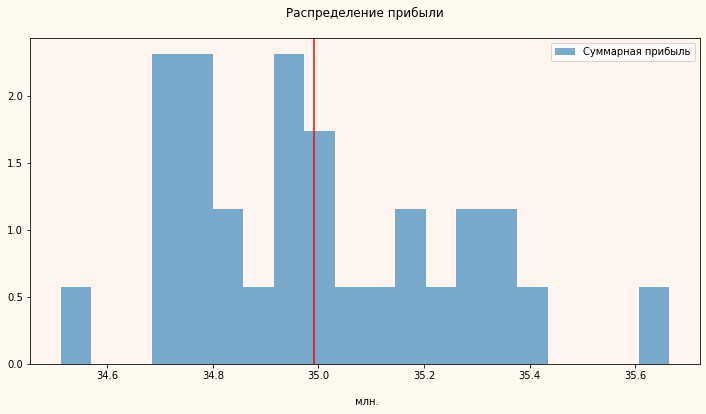

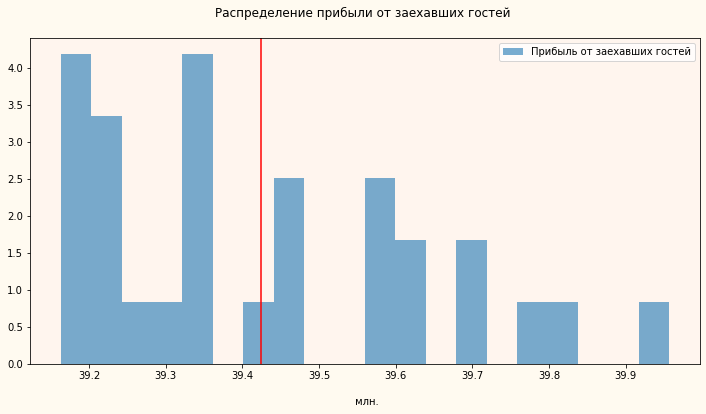

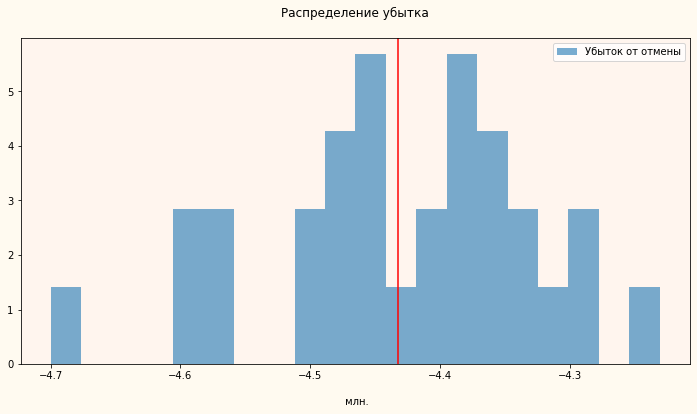

In [113]:
histogram(profit_distribution, profit_mean, 'Суммарная прибыль', 'Распределение прибыли\n')
histogram(distribution_arrived, arrived_mean, 'Прибыль от заехавших гостей', 'Распределение прибыли от заехавших гостей \n')
histogram(distribution_cancelled, cancelled_mean, 'Убыток от отмены', 'Распределение убытка\n')

На графиках мы видим, что прибыль после нововведения распределенена между 34.5 и 35.5 миллионами. При этом прибыль от заехавших гостей распеределена очень близко к значению до нововведения, что абсолютно логично, потому что нововведение не влияет на людей, которые и так бы не отменили бронирования. При этом убыток от тех, кто отменил распределён в районе 4.5 миллионов.

Сравним теперь значения прибыли без системы депозитов и с ней. 

In [114]:
# Таблица
result = (
    pd.DataFrame([[profit_mean/10**6, arrived_mean/10**6, cancelled_mean/10**6], 
                  [profit_test_before/10**6, profit_arrived_test_before/10**6, loss_cancelled_test_before/10**6]],
    index=['После', 'До'], 
    columns=['Прибыль, млн.', 'Прибыль от заехавших гостей, млн.', 'Убыток от отменённых бронирований, млн.']
))
(result.
 style.
 format({'Прибыль, млн.':"{:,.2f}",'Прибыль от заехавших гостей, млн.':"{:,.2f}", 'Убыток от отменённых бронирований, млн.':"{:,.2f}"})
)

,"Прибыль, млн.","Прибыль от заехавших гостей, млн.","Убыток от отменённых бронирований, млн."
После,34.99,39.42,-4.43
До,20.30,39.46,-19.16


Как мы видим, после нововведения прибыль выросла почти что на 15 миллионов за счёт уменьшения убытка от отменённых бронирований. Это покрывает бюджет на разработку в 400000. 

В данном разделе я отобрала алгоритм борьбы с дисбалансом и модель для предсказания отмены бронировния. Наилучшую метрику на кросс-валидации показала модель дерева решений глубины 4 совмещенная с алгоритмом андерсамплинга. На тестовой выборке метрика recall была 0.68. Далее я построила функцию прибыли после нововведения, используя предсказания модели и бутстрапом посмотроила распределение прибыли. С помощью системы депозитов прибыль удалось увеличить практически на 15 миллионов за тестовый период, что в разы окупило бюджет на разработку. 

### Шаг 5. Опишите портрет «ненадёжного» клиента

Для описания портрета ненадёжного клиента мы посмотрим, на то, какие показатели увеличивают веротяность того, что человек отменит бронирование.

Восстановим наши фичи после препроцессора и их новые имена.

In [115]:
features_train_encoded = preprocessor.transform(features_train)
new_features_names = preprocessor.get_feature_names_out()

In [116]:
data_features_importance = (
    pd.DataFrame({'features_names':new_features_names,'feature_importance':best_model.feature_importances_}
))

In [117]:
data_features_importance = data_features_importance.sort_values('feature_importance', ascending=False).head(5)

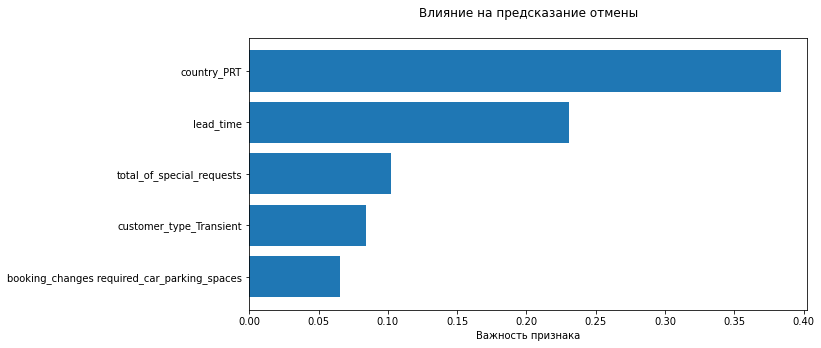

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.barh(data_features_importance['features_names'], data_features_importance['feature_importance'] );
ax.invert_yaxis() 
ax.set_xlabel('Важность признака')
ax.set_title('Влияние на предсказание отмены\n');

Таким образом наша модель предсказывает, что типичный клиент склонный к отказу это клиент из Португалии, который очень заранее бронирует номер, не связанный с договором или групповым заездом, и с большим колличеством специальных требований.

### Шаг 6. Напишите общий вывод

В данном проекте я исследовала перспективу введения новой функциональности в систему бронирования, которая будет определять, что клиент с большой долей вероятности может отменить бронирование и будет предлагать ему внести депозит.

У меня были данные о бронированиях изначально разделённые на обучающую и тестовую выборки. В данных не было пропусков, были дополнительные пробелы в категориальных переменных, которые я обработала. 

Я добавила в данные переменную о том, сколько номеров уже было занято на интересующий клиента период на момент бронирования.

Я создала функцию, которая подсчитывает прибыль отеля и показывает убыток от отменённых бронирований. Оказалось, что отель теряет практически половину прибыли из-за отмен бронирования. 

Далее, я посмотрела на переменные, которые на первой тестовой модели оказывают меньшее влияние на таргет, чем случайная величина и удалила эти показатели. 

Потом я провела поиск оптимальной комбинации из алгоритма балансировки классов и классификатора с помощью кросс-валидации. Оптимальной оказалась комбинация из андерсамплинга и модели дерева решений. На тестовой выборке модель показала рекол 0.68

После  этого я на тестовой выборке оценила прибыль, которую отель может получать, запрашивая депозиты у тех клиентов, которых модель определяет как склонных к отмене бронирования. Я оценила распределение прибыли после нововведения и оказалось, что за временной период тестовой выборки отель мог увеличить прибыль в среднем примерно на 15 млн., что окупает бюджет разработки и показывает, что депозиты нужно ввести.

В последней части проекта я посмотрела на то, какие переменные наиболее влияют на то, что модель классифицирует клиента как склонного к отмене. Оказалось, что такой клиент это клиент из Португалии, который бронирует сильно заранее, у которого много дополнительных требований и который не связан ни с групповым бронированием ни с юридическим договором. 